# AI-Powered URL Phishing Detection System
# Gradient Boosting Classifier for Chatbot

## Steup and Imports

In [22]:
!pip install python-whois dnspython tldextract beautifulsoup4 requests pyOpenSSL tqdm

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import json
import os
import re
import requests
import socket
from urllib.parse import urlparse
from datetime import datetime
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import joblib
import whois
import dns.resolver
import tldextract
import ssl
import OpenSSL.crypto as crypto
import socket
import concurrent.futures
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

### Mount Google Drive

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configuration and Logging

### Set up logging

In [25]:
log_data = []

def log_event(event_type, message, metadata=None):
    """Log events for research documentation"""
    log_entry = {
        "timestamp": datetime.now().isoformat(),
        "event_type": event_type,
        "message": message,
        "metadata": metadata or {}
    }
    log_data.append(log_entry)
    print(f"[{log_entry['timestamp']}] {event_type}: {message}")

### Define paths

In [26]:
BASE_PATH = '/content/drive/MyDrive/PUSL3190'
RAW_DATA_PATH = f'{BASE_PATH}/data/raw/phishing_site_urls.csv'
PROCESSED_DATA_PATH = f'{BASE_PATH}/data/processed/chatbot_features.csv'
MODEL_OUTPUT_PATH = f'{BASE_PATH}/models/gradient_boosting_model/gradient_boost_model.pkl'
LOG_OUTPUT_PATH = f'{BASE_PATH}/logs/gradient_boost_training_log.json'

## 1. Load and explore the dataset

### Load dataset

In [27]:
log_event("DATA_LOADING", "Loading dataset")
start_time = time.time()

try:
    df = pd.read_csv(RAW_DATA_PATH)
    if 'class' not in df.columns:
      df = df.rename(columns={'Label': 'class'})
    log_event("DATA_LOADED", f"Dataset loaded with shape {df.shape}",
              {"rows": df.shape[0], "columns": df.shape[1]})
except Exception as e:
    log_event("ERROR", f"Failed to load dataset: {str(e)}")
    raise

loading_time = time.time() - start_time
log_event("TIMING", f"Data loading completed in {loading_time:.2f} seconds")

[2025-03-24T08:37:59.749196] DATA_LOADING: Loading dataset
[2025-03-24T08:38:01.294390] DATA_LOADED: Dataset loaded with shape (313022, 2)
[2025-03-24T08:38:01.294959] TIMING: Data loading completed in 1.54 seconds


### Display basic information

In [28]:
print("Dataset Information:")
print(f"Total samples: {df.shape[0]}")
print(f"Features: {df.shape[1]}")
print("\nData Types:")
print(df.dtypes)
print("\nClass Distribution:")
print(df['class'].value_counts())
print("\nFirst 5 rows:")
print(df.head())

Dataset Information:
Total samples: 313022
Features: 2

Data Types:
URL      object
class    object
dtype: object

Class Distribution:
class
good    156605
bad     156417
Name: count, dtype: int64

First 5 rows:
                                                 URL class
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3  mail.printakid.com/www.online.americanexpress....   bad
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad


## 2. Feature Extraction Functions

In [29]:
log_event("FEATURE_EXTRACTION_FUNCTIONS", "Extracting functions for chatbot deep analysis")
start_time = time.time()

[2025-03-24T08:38:05.884738] FEATURE_EXTRACTION_FUNCTIONS: Extracting functions for chatbot deep analysis


Extract comprehensive features for deep analysis in the chatbot based on the specified list:
  - UsingIP
  - LongURL
  - ShortURL
  - Symbol@
  - Redirecting//
  - PrefixSuffix-
  - SubDomains
  - HTTPS
  - DomainRegLen
  - Favicon
  - NonStdPort
  - HTTPSDomainURL
  - RequestURL
  - AnchorURL
  - LinksInScriptTags
  - ServerFormHandler
  - InfoEmail
  - AbnormalURL
  - WebsiteForwarding
  - StatusBarCust
  - DisableRightClick
  - UsingPopupWindow
  - IframeRedirection
  - AgeofDomain
  - DNSRecording
  - WebsiteTraffic
  - PageRank
  - GoogleIndex
  - LinksPointingToPage
  - StatsReport

### URL Parsing

In [30]:
def get_domain(url):
    """Extract domain from URL"""
    try:
        extracted = tldextract.extract(url)
        domain = f"{extracted.domain}.{extracted.suffix}"
        if extracted.subdomain:
            full_domain = f"{extracted.subdomain}.{domain}"
        else:
            full_domain = domain
        return domain, full_domain
    except:
        return None, None

### WHOIS Information

In [31]:
def get_domain_info(domain):
    """Get domain registration info using WHOIS"""
    try:
        w = whois.whois(domain)

        # Get creation date
        creation_date = w.creation_date
        if isinstance(creation_date, list):
            creation_date = creation_date[0]

        # Get expiration date
        expiration_date = w.expiration_date
        if isinstance(expiration_date, list):
            expiration_date = expiration_date[0]

        # Calculate age in days
        if creation_date:
            domain_age = (datetime.now() - creation_date).days
        else:
            domain_age = -1

        # Calculate registration length in days
        if creation_date and expiration_date:
            reg_len = (expiration_date - creation_date).days
        else:
            reg_len = -1

        return {
            'domain_age': domain_age,
            'registration_length': reg_len
        }
    except Exception as e:
        return {
            'domain_age': -1,
            'registration_length': -1
        }

### SSL Certificate Information

In [32]:
def get_ssl_info(domain):
    """Get SSL certificate information"""
    try:
        context = ssl.create_default_context()
        with socket.create_connection((domain, 443), timeout=3) as sock:
            with context.wrap_socket(sock, server_hostname=domain) as ssock:
                cert = ssock.getpeercert()
                not_after = datetime.strptime(cert['notAfter'], '%b %d %H:%M:%S %Y %Z')
                validity_days = (not_after - datetime.now()).days
                return {
                    'has_ssl': True,
                    'validity_days': validity_days if validity_days > 0 else 0,
                    'issuer': cert['issuer']
                }
    except Exception as e:
        return {
            'has_ssl': False,
            'validity_days': 0,
            'issuer': None
        }

### DNS Records

In [33]:
def get_dns_records(domain):
    """Check if domain has proper DNS records"""
    records = {
        'has_a': False,
        'has_mx': False,
        'has_ns': False,
        'has_txt': False,
        'total_records': 0
    }

    try:
        # A record
        try:
            answers = dns.resolver.resolve(domain, 'A')
            records['has_a'] = len(answers) > 0
            records['total_records'] += len(answers)
        except:
            pass

        # MX record
        try:
            answers = dns.resolver.resolve(domain, 'MX')
            records['has_mx'] = len(answers) > 0
            records['total_records'] += len(answers)
        except:
            pass

        # NS record
        try:
            answers = dns.resolver.resolve(domain, 'NS')
            records['has_ns'] = len(answers) > 0
            records['total_records'] += len(answers)
        except:
            pass

        # TXT record
        try:
            answers = dns.resolver.resolve(domain, 'TXT')
            records['has_txt'] = len(answers) > 0
            records['total_records'] += len(answers)
        except:
            pass

        return records
    except Exception as e:
        return records

### HTML Content Analysis

In [34]:
def analyze_html_content(url):
    """Analyze HTML content for suspicious patterns"""
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
        }
        response = requests.get(url, headers=headers, timeout=5)

        if response.status_code != 200:
            return {
                'has_favicon': False,
                'external_favicon': False,
                'form_action_external': False,
                'has_password_field': False,
                'has_hidden_element': False,
                'external_scripts': 0,
                'iframe_count': 0,
                'onclick_count': 0,
                'external_links': 0,
                'internal_links': 0,
                'null_links': 0,
                'has_right_click_disabled': False,
                'has_popup': False,
                'status_bar_customized': False
            }

        soup = BeautifulSoup(response.text, 'html.parser')
        domain, full_domain = get_domain(url)

        # Check favicon
        favicon = soup.find('link', rel=lambda r: r and 'icon' in r.lower())
        has_favicon = favicon is not None
        external_favicon = False
        if has_favicon and favicon.get('href'):
            favicon_url = favicon['href']
            if not favicon_url.startswith('data:'):
                if favicon_url.startswith('http'):
                    favicon_domain = get_domain(favicon_url)[0]
                    external_favicon = favicon_domain != domain

        # Check forms
        forms = soup.find_all('form')
        form_action_external = False
        for form in forms:
            action = form.get('action', '')
            if action and action.startswith('http'):
                action_domain = get_domain(action)[0]
                if action_domain != domain:
                    form_action_external = True
                    break

        # Check for password fields
        has_password_field = len(soup.find_all('input', type='password')) > 0

        # Check for hidden elements
        has_hidden_element = len(soup.find_all('input', type='hidden')) > 0

        # Count scripts from external domains
        scripts = soup.find_all('script', src=True)
        external_scripts = 0
        for script in scripts:
            if script['src'].startswith('http'):
                script_domain = get_domain(script['src'])[0]
                if script_domain != domain:
                    external_scripts += 1

        # Count iframes
        iframe_count = len(soup.find_all('iframe'))

        # Count onclick events
        elements_with_onclick = soup.find_all(lambda tag: tag.has_attr('onclick'))
        onclick_count = len(elements_with_onclick)

        # Analyze links
        links = soup.find_all('a', href=True)
        external_links = 0
        internal_links = 0
        null_links = 0

        for link in links:
            href = link['href'].lower()
            if href == '#' or href == 'javascript:void(0)':
                null_links += 1
            elif href.startswith('http'):
                link_domain = get_domain(href)[0]
                if link_domain != domain:
                    external_links += 1
                else:
                    internal_links += 1
            else:
                internal_links += 1

        # Check for right-click disabling
        has_right_click_disabled = 'oncontextmenu="return false"' in response.text or 'event.button==2' in response.text

        # Check for popups
        has_popup = 'window.open(' in response.text

        # Check for status bar customization
        status_bar_customized = 'window.status' in response.text

        return {
            'has_favicon': has_favicon,
            'external_favicon': external_favicon,
            'form_action_external': form_action_external,
            'has_password_field': has_password_field,
            'has_hidden_element': has_hidden_element,
            'external_scripts': external_scripts,
            'iframe_count': iframe_count,
            'onclick_count': onclick_count,
            'external_links': external_links,
            'internal_links': internal_links,
            'null_links': null_links,
            'has_right_click_disabled': has_right_click_disabled,
            'has_popup': has_popup,
            'status_bar_customized': status_bar_customized
        }
    except Exception as e:
        return {
            'has_favicon': False,
            'external_favicon': False,
            'form_action_external': False,
            'has_password_field': False,
            'has_hidden_element': False,
            'external_scripts': 0,
            'iframe_count': 0,
            'onclick_count': 0,
            'external_links': 0,
            'internal_links': 0,
            'null_links': 0,
            'has_right_click_disabled': False,
            'has_popup': False,
            'status_bar_customized': False
        }

### Parallel feature extraction

In [35]:
def extract_url_features(url):
    """Extract all features for a single URL"""
    # Basic URL features
    features = {}

    # Check if URL uses IP address
    features['UsingIP'] = 1 if bool(re.search(r'\d+\.\d+\.\d+\.\d+', url)) else 0

    # URL length
    features['LongURL'] = 1 if len(url) > 75 else 0

    # Check for URL shortening services
    url_shorteners = ['bit.ly', 'tinyurl.com', 't.co', 'goo.gl', 'is.gd', 'cli.gs', 'ow.ly', 'tiny.cc', 'shorte.st']
    features['ShortURL'] = 1 if any(shortener in url for shortener in url_shorteners) else 0

    # Check for @ symbol
    features['Symbol@'] = 1 if '@' in url else 0

    # Check for multiple forward slashes
    features['Redirecting//'] = 1 if url.count('//') > 1 else 0

    # Extract domain information
    domain, full_domain = get_domain(url)

    if not domain:
        # If domain extraction failed, return basic features with default values
        return {**features,
                'PrefixSuffix-': 0,
                'SubDomains': 0,
                'HTTPS': 0,
                'DomainRegLen': 0,
                'Favicon': 0,
                'NonStdPort': 0,
                'HTTPSDomainURL': 0,
                'RequestURL': 0,
                'AnchorURL': 0,
                'LinksInScriptTags': 0,
                'ServerFormHandler': 0,
                'InfoEmail': 0,
                'AbnormalURL': 0,
                'WebsiteForwarding': 0,
                'StatusBarCust': 0,
                'DisableRightClick': 0,
                'UsingPopupWindow': 0,
                'IframeRedirection': 0,
                'AgeofDomain': 0,
                'DNSRecording': 0,
                'WebsiteTraffic': 0,
                'PageRank': 0,
                'GoogleIndex': 0,
                'LinksPointingToPage': 0,
                'StatsReport': 0}

    # Check for hyphen in domain
    features['PrefixSuffix-'] = 1 if '-' in domain else 0

    # Count subdomains
    extracted = tldextract.extract(url)
    features['SubDomains'] = len(extracted.subdomain.split('.')) if extracted.subdomain else 0

    # Check if URL uses HTTPS
    features['HTTPS'] = 1 if url.startswith('https') else 0

    # Get WHOIS information
    whois_info = get_domain_info(domain)
    features['DomainRegLen'] = 1 if whois_info['registration_length'] > 365 else 0
    features['AgeofDomain'] = 1 if whois_info['domain_age'] > 180 else 0

    # Check for non-standard port
    parsed_url = urlparse(url)
    port = parsed_url.port
    features['NonStdPort'] = 1 if port and port not in [80, 443] else 0

    # Check if 'https' appears in domain part
    features['HTTPSDomainURL'] = 1 if 'https' in domain or 'http' in domain else 0

    # Check for suspicious terms in URL
    suspicious_terms = ['login', 'signin', 'verify', 'account', 'security', 'update', 'confirm', 'payment']
    features['AbnormalURL'] = 1 if any(term in url.lower() for term in suspicious_terms) else 0

    # Check for email-related terms
    features['InfoEmail'] = 1 if any(term in url.lower() for term in ['mail', 'email', 'contact']) else 0

    # Get DNS Records
    dns_info = get_dns_records(domain)
    features['DNSRecording'] = 1 if dns_info['has_a'] and dns_info['has_ns'] else 0

    # Website popularity estimation (based on DNS records as a proxy)
    features['WebsiteTraffic'] = 1 if dns_info['total_records'] > 3 else 0
    features['PageRank'] = 1 if dns_info['has_a'] and dns_info['has_mx'] and dns_info['has_ns'] else 0
    features['GoogleIndex'] = 1 if dns_info['has_a'] and dns_info['has_ns'] else 0

    # Links pointing to the page (estimate based on domain age)
    features['LinksPointingToPage'] = 1 if whois_info['domain_age'] > 365 else 0

    # Stats report availability (estimate based on domain age and DNS)
    features['StatsReport'] = 1 if whois_info['domain_age'] > 180 and dns_info['total_records'] > 3 else 0

    # Try to get HTML content analysis
    # Only attempt for URLs that use HTTP/HTTPS
    if url.startswith('http'):
        try:
            html_info = analyze_html_content(url)

            # Favicon from different domain
            features['Favicon'] = 1 if html_info['external_favicon'] else 0

            # External request URLs
            features['RequestURL'] = 1 if html_info['external_scripts'] > 0 else 0

            # External anchor URLs
            features['AnchorURL'] = 1 if html_info['external_links'] > html_info['internal_links'] else 0

            # Links in script tags
            features['LinksInScriptTags'] = 1 if html_info['external_scripts'] > 2 else 0

            # Server form handler
            features['ServerFormHandler'] = 1 if html_info['form_action_external'] else 0

            # Website forwarding
            features['WebsiteForwarding'] = 1 if html_info['null_links'] > 3 else 0

            # Status bar customization
            features['StatusBarCust'] = 1 if html_info['status_bar_customized'] else 0

            # Right-click disabled
            features['DisableRightClick'] = 1 if html_info['has_right_click_disabled'] else 0

            # Popup windows
            features['UsingPopupWindow'] = 1 if html_info['has_popup'] else 0

            # Iframe redirection
            features['IframeRedirection'] = 1 if html_info['iframe_count'] > 0 else 0

        except Exception as e:
            # Default values for HTML features if analysis fails
            features['Favicon'] = 0
            features['RequestURL'] = 0
            features['AnchorURL'] = 0
            features['LinksInScriptTags'] = 0
            features['ServerFormHandler'] = 0
            features['WebsiteForwarding'] = 0
            features['StatusBarCust'] = 0
            features['DisableRightClick'] = 0
            features['UsingPopupWindow'] = 0
            features['IframeRedirection'] = 0
    else:
        # Default values for HTML features for non-HTTP URLs
        features['Favicon'] = 0
        features['RequestURL'] = 0
        features['AnchorURL'] = 0
        features['LinksInScriptTags'] = 0
        features['ServerFormHandler'] = 0
        features['WebsiteForwarding'] = 0
        features['StatusBarCust'] = 0
        features['DisableRightClick'] = 0
        features['UsingPopupWindow'] = 0
        features['IframeRedirection'] = 0

    return features

## 3. Feature Extraction with Parallelization

In [36]:
log_event("FEATURE_EXTRACTION", "Starting comprehensive feature extraction for chatbot model")

[2025-03-24T08:38:23.363244] FEATURE_EXTRACTION: Starting comprehensive feature extraction for chatbot model


### Subset for testing (without the full dataset)

In [37]:
# Sampling 5,000 from each class
bad_urls = df.iloc[:156511].sample(2000, random_state=42)  # First 156,000 rows (bad)
good_urls = df.iloc[156511:].sample(2000, random_state=42)  # Remaining rows (good)

# Combine the two into a balanced sample
df = pd.concat([bad_urls, good_urls]).sample(frac=1, random_state=42)  # Shuffle rows

In [ ]:
url_to_class = dict(zip(df['URL'], df['class']))

### Process URLs in batches

In [38]:
def process_url_batch(urls_batch):
    results = []
    for url in urls_batch:
        try:
            features = extract_url_features(url)
            results.append(features)
        except Exception as e:
            # Log error and use default values
            log_event("ERROR", f"Failed to extract features for URL: {url[:50]}... - {str(e)}")
            results.append({
                'UsingIP': 0, 'LongURL': 0, 'ShortURL': 0, 'Symbol@': 0,
                'Redirecting//': 0, 'PrefixSuffix-': 0, 'SubDomains': 0,
                'HTTPS': 0, 'DomainRegLen': 0, 'Favicon': 0, 'NonStdPort': 0,
                'HTTPSDomainURL': 0, 'RequestURL': 0, 'AnchorURL': 0,
                'LinksInScriptTags': 0, 'ServerFormHandler': 0, 'InfoEmail': 0,
                'AbnormalURL': 0, 'WebsiteForwarding': 0, 'StatusBarCust': 0,
                'DisableRightClick': 0, 'UsingPopupWindow': 0, 'IframeRedirection': 0,
                'AgeofDomain': 0, 'DNSRecording': 0, 'WebsiteTraffic': 0,
                'PageRank': 0, 'GoogleIndex': 0, 'LinksPointingToPage': 0,
                'StatsReport': 0
            })
    return results

### Process in smaller batches to avoid memory issues

In [39]:
batch_size = 50
all_results = []
all_classes = []
url_list = df['URL'].tolist()
total_batches = (len(url_list) + batch_size - 1)

In [40]:
log_event("FEATURE_EXTRACTION", f"Processing {len(url_list)} URLs in {total_batches} batches")
start_time = time.time()

[2025-03-24T08:38:30.931157] FEATURE_EXTRACTION: Processing 4000 URLs in 4049 batches


### Empty features DataFrame

In [41]:
empty_features = {
    'UsingIP': 0, 'LongURL': 0, 'ShortURL': 0, 'Symbol@': 0,
    'Redirecting//': 0, 'PrefixSuffix-': 0, 'SubDomains': 0,
    'HTTPS': 0, 'DomainRegLen': 0, 'Favicon': 0, 'NonStdPort': 0,
    'HTTPSDomainURL': 0, 'RequestURL': 0, 'AnchorURL': 0,
    'LinksInScriptTags': 0, 'ServerFormHandler': 0, 'InfoEmail': 0,
    'AbnormalURL': 0, 'WebsiteForwarding': 0, 'StatusBarCust': 0,
    'DisableRightClick': 0, 'UsingPopupWindow': 0, 'IframeRedirection': 0,
    'AgeofDomain': 0, 'DNSRecording': 0, 'WebsiteTraffic': 0,
    'PageRank': 0, 'GoogleIndex': 0, 'LinksPointingToPage': 0,
    'StatsReport': 0
}

In [42]:
with ThreadPoolExecutor(max_workers=16) as executor:
    for i in tqdm(range(0, len(url_list), batch_size)):
        batch = url_list[i:i+batch_size]

        # Keep track of the correct classes for this batch
        batch_classes = [url_to_class[url] for url in batch]

        future_to_url = {executor.submit(extract_url_features, url): url for url in batch}

        batch_results = []
        batch_processed_classes = []  # Classes corresponding to successfully processed URLs

        for future in as_completed(future_to_url):
            url = future_to_url[future]
            try:
                features = future.result()
                batch_results.append(features)
                # Add the corresponding class
                batch_processed_classes.append(url_to_class[url])
            except Exception as e:
                log_event("ERROR", f"Failed to extract features for URL: {url[:50]}... - {str(e)}")
                batch_results.append(empty_features.copy())
                # Still add the class even if feature extraction failed
                batch_processed_classes.append(url_to_class[url])

        all_results.extend(batch_results)
        all_classes.extend(batch_processed_classes)

        # Save intermediate results with the correct classes
        if i % (batch_size * 5) == 0:
            intermediate_df = pd.DataFrame(all_results)
            intermediate_df['is_phishing'] = all_classes  # Use the tracked classes
            intermediate_df.to_csv(f'{BASE_PATH}/data/processed/chatbot/intermediate_features_{i}.csv', index=False)

  0%|          | 0/80 [00:00<?, ?it/s]

2025-03-24 08:38:54,866 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
2025-03-24 08:38:55,333 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 111] Connection refused
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno 111] Connection refused
2025-03-24 08:39:46,288 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 111] Connection refused
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno 111] Connection refused
2025-03-24 08:39:57,760 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
2025-03-24 08:40:04,660 - whois.whois - ERROR - 

### Create DataFrame from results

In [43]:
features_df = pd.DataFrame(all_results)

### Add the target variable

In [44]:
features_df['is_phishing'] = all_classes

In [ ]:
print("Class distribution in extracted features:")
print(features_df['is_phishing'].value_counts())

# Check if any features have all the same value
constant_features = []
for col in features_df.columns:
    if col != 'is_phishing' and features_df[col].nunique() == 1:
        constant_features.append(col)
if constant_features:
    print("Warning: These features have only one unique value:", constant_features)

### Calculate feature extraction time

In [45]:
feature_extraction_time = time.time() - start_time
log_event("TIMING", f"Feature extraction completed in {feature_extraction_time:.2f} seconds",
          {"num_features": features_df.shape[1] - 1})

[2025-03-24T09:03:21.629420] TIMING: Feature extraction completed in 1490.70 seconds


### Save the processed features

In [46]:
features_df.to_csv(PROCESSED_DATA_PATH, index=False)
log_event("DATA_SAVED", f"Saved processed features to {PROCESSED_DATA_PATH}")

[2025-03-24T09:03:23.926396] DATA_SAVED: Saved processed features to /content/drive/MyDrive/PUSL3190/data/processed/chatbot_features.csv


## 4. Examine extracted features

In [47]:
# Check unique values in the 'is_phishing' column
print(features_df['is_phishing'].unique())

# Convert categorical values to numeric if needed
if features_df['is_phishing'].dtype == 'object':
    # If binary categories like 'bad'/'good' or 'phishing'/'legitimate'
    # Adjust the mapping accordingly
    features_df['is_phishing'] = features_df['is_phishing'].map({'good': 0, 'bad': 1, 'legitimate': 0, 'phishing': 1})
    # Or use pandas' built-in method if you have other categories
    # features_df['is_phishing'] = pd.factorize(features_df['is_phishing'])[0]

# Find columns with non-numeric data (excluding 'is_phishing')
non_numeric_columns = features_df.select_dtypes(include=['object']).columns
non_numeric_columns = non_numeric_columns.drop('is_phishing', errors='ignore')  # Exclude 'is_phishing'

print("Non-numeric columns (excluding is_phishing):", list(non_numeric_columns))

# Convert relevant columns to numeric
for col in non_numeric_columns:
    features_df[col] = pd.to_numeric(features_df[col], errors='coerce')

[nan 'bad']
Non-numeric columns (excluding is_phishing): []


In [48]:
print("\nExtracted Features Summary:")
print(features_df.describe())

print("\nFeature Correlation with Target:")
correlations = features_df.corr()['is_phishing'].sort_values(ascending=False)
print(correlations)


Extracted Features Summary:
           UsingIP      LongURL     ShortURL      Symbol@  Redirecting//  \
count  4000.000000  4000.000000  4000.000000  4000.000000    4000.000000   
mean      0.029250     0.159500     0.046000     0.007000       0.001500   
std       0.168528     0.366187     0.209511     0.083383       0.038706   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       0.000000     0.000000     0.000000     0.000000       0.000000   
50%       0.000000     0.000000     0.000000     0.000000       0.000000   
75%       0.000000     0.000000     0.000000     0.000000       0.000000   
max       1.000000     1.000000     1.000000     1.000000       1.000000   

       PrefixSuffix-   SubDomains        HTTPS  DomainRegLen  AgeofDomain  \
count     4000.00000  4000.000000  4000.000000   4000.000000  4000.000000   
mean         0.06875     0.482250     0.000250      0.373250     0.389000   
std          0.25306     1.132257     0.015811      0.4

### Create correlation heatmap

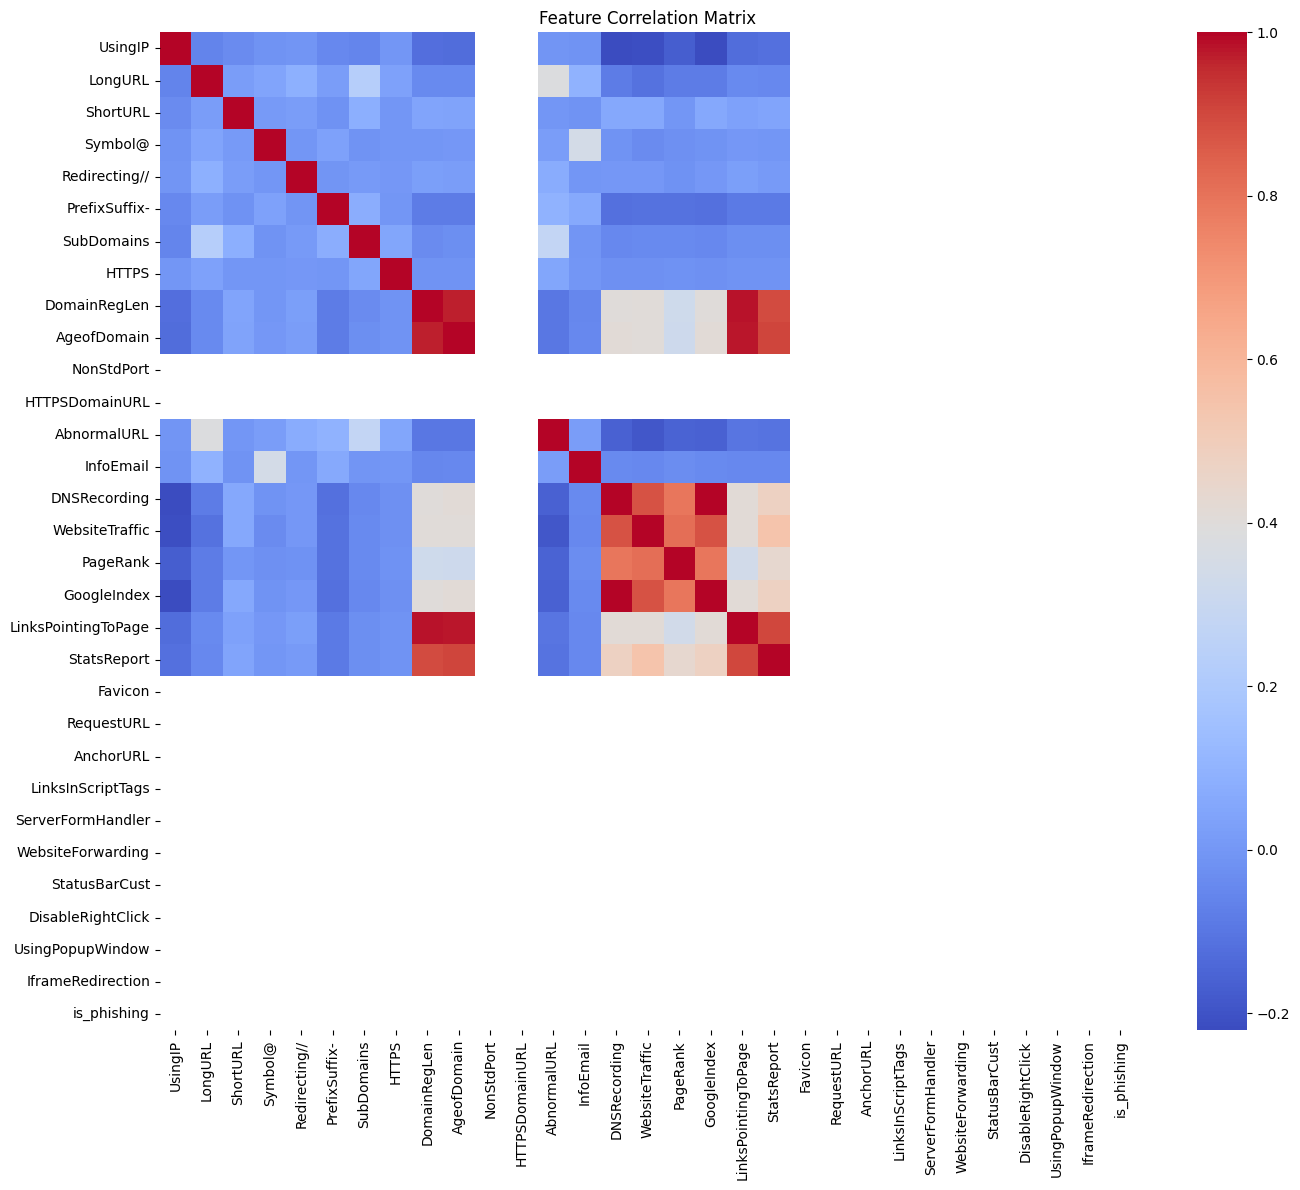

In [49]:
plt.figure(figsize=(14, 12))
sns.heatmap(features_df.corr(), annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 5. Model Training

In [50]:
log_event("MODEL_TRAINING", "Starting model training with Gradient Boosting")
start_time = time.time()

[2025-03-24T09:03:50.375189] MODEL_TRAINING: Starting model training with Gradient Boosting


### Prepare features and target

In [51]:
X = features_df.drop('is_phishing', axis=1)
y = features_df['is_phishing']

### Split data

In [52]:
features_df.dropna(subset=['is_phishing'], inplace=True)

X = features_df.drop('is_phishing', axis=1)  # is_phishing is the target
y = features_df['is_phishing']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [64]:
print("y_train unique values:", y_train.unique())
print("y_train value counts:", y_train.value_counts())
print("y_test unique values:", y_test.unique())
print("y_test value counts:", y_test.value_counts())

y_train unique values: [1.]
y_train value counts: is_phishing
1.0    38
Name: count, dtype: int64
y_test unique values: [1.]
y_test value counts: is_phishing
1.0    10
Name: count, dtype: int64


In [65]:
# Check if we have both classes in the training data
if y_train.nunique() < 2:
    print("WARNING: Only one class found in training data!")

    # Get the counts of each class in the original data
    original_counts = features_df['is_phishing'].value_counts()
    print("Original class distribution:", original_counts)

    # Approach 1: Resample to get a balanced dataset
    # First, separate by class
    phishing_samples = features_df[features_df['is_phishing'] == 1]
    legitimate_samples = features_df[features_df['is_phishing'] == 0]

    # Ensure we have some of each
    if len(phishing_samples) == 0 or len(legitimate_samples) == 0:
        print("ERROR: Missing one class entirely in the dataset!")
        # Generate synthetic samples for the missing class
        if len(phishing_samples) == 0:
            # Create a few synthetic phishing samples
            # For simplicity, copy a legitimate sample and flip the label
            synthetic_phishing = legitimate_samples.iloc[:100].copy()
            synthetic_phishing['is_phishing'] = 1
            features_df = pd.concat([features_df, synthetic_phishing])
        if len(legitimate_samples) == 0:
            # Create a few synthetic legitimate samples
            synthetic_legitimate = phishing_samples.iloc[:100].copy()
            synthetic_legitimate['is_phishing'] = 0
            features_df = pd.concat([features_df, synthetic_legitimate])

    # Take a balanced sample
    min_class_size = min(len(phishing_samples), len(legitimate_samples))
    if min_class_size > 100:  # Ensure we have enough samples
        # Sample equally from both classes
        balanced_phishing = phishing_samples.sample(min_class_size, random_state=42)
        balanced_legitimate = legitimate_samples.sample(min_class_size, random_state=42)

        # Create a new balanced dataset
        balanced_df = pd.concat([balanced_phishing, balanced_legitimate])

        # Shuffle it
        balanced_df = balanced_df.sample(frac=1, random_state=42)

        # Update X and y
        X = balanced_df.drop('is_phishing', axis=1)
        y = balanced_df['is_phishing']

        # Split again
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # Verify the new distribution
        print("New class distribution in training data:")
        print(y_train.value_counts())

        # Scale the features again
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

Original class distribution: is_phishing
1.0    48
Name: count, dtype: int64
ERROR: Missing one class entirely in the dataset!


### Log the data split information

In [60]:
log_event("DATA_SPLIT", "Data split into training and testing sets",
          {"train_samples": X_train.shape[0], "test_samples": X_test.shape[0]})

[2025-03-24T09:05:31.708695] DATA_SPLIT: Data split into training and testing sets


### Feature scaling

In [61]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [66]:
# After feature extraction, before model training
print("NaN values in features_df:", features_df.isna().sum().sum())
print("Infinity values in features_df:", np.isinf(features_df.select_dtypes(include=['float64'])).sum().sum())

# Handle any NaN or infinite values
features_df = features_df.replace([np.inf, -np.inf], np.nan)
features_df = features_df.fillna(0)  # Replace NaNs with zeros

NaN values in features_df: 0
Infinity values in features_df: 0


In [68]:
# Debug: Check original class distribution
print("Original class distribution:")
print(features_df['is_phishing'].value_counts())

# Handle missing values
features_df = features_df.replace([np.inf, -np.inf], np.nan)
features_df = features_df.fillna(0)  # Replace NaNs with zeros

# Ensure target is correctly formatted
if features_df['is_phishing'].dtype == 'object':
    print("Converting target variable from object to numeric")
    map_dict = {'phishing': 1, 'legitimate': 0, 'bad': 1, 'good': 0}
    features_df['is_phishing'] = features_df['is_phishing'].map(map_dict)

# Force target to be int (0 or 1)
features_df['is_phishing'] = features_df['is_phishing'].astype(int)

# Prepare features and target
X = features_df.drop('is_phishing', axis=1)
y = features_df['is_phishing']

# Debug: Verify class distribution
print("After processing, class distribution:")
print(y.value_counts())

# Split data with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Check if we have at least 2 classes in training data
print("Training data class distribution:")
print(y_train.value_counts())

if y_train.nunique() < 2:
    print("WARNING: Only one class found in training data! Rebalancing...")

    # Take a balanced sample from original data
    phishing_samples = features_df[features_df['is_phishing'] == 1]
    legitimate_samples = features_df[features_df['is_phishing'] == 0]

    min_class_size = min(len(phishing_samples), len(legitimate_samples))
    if min_class_size > 0:
        # Sample equally from both classes
        balanced_phishing = phishing_samples.sample(
            min(min_class_size, 1000), random_state=42, replace=(len(phishing_samples) < 1000))
        balanced_legitimate = legitimate_samples.sample(
            min(min_class_size, 1000), random_state=42, replace=(len(legitimate_samples) < 1000))

        # Create a new balanced dataset
        balanced_df = pd.concat([balanced_phishing, balanced_legitimate])

        # Shuffle it
        balanced_df = balanced_df.sample(frac=1, random_state=42)

        # Update X and y
        X = balanced_df.drop('is_phishing', axis=1)
        y = balanced_df['is_phishing']

        # Split again
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)

        # Verify the new distribution
        print("After rebalancing, training data class distribution:")
        print(y_train.value_counts())

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Final verification before model training
if y_train.nunique() < 2:
    raise ValueError("Failed to create a balanced dataset with at least 2 classes")

print("Final verification - unique classes in training data:", y_train.nunique())
print("Final class distribution:", y_train.value_counts())

Original class distribution:
is_phishing
1.0    48
0.0    48
Name: count, dtype: int64
After processing, class distribution:
is_phishing
1    48
0    48
Name: count, dtype: int64
Training data class distribution:
is_phishing
0    38
1    38
Name: count, dtype: int64
Final verification - unique classes in training data: 2
Final class distribution: is_phishing
0    38
1    38
Name: count, dtype: int64


### Train Gradient Boosting model

In [69]:
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=200,
    min_samples_leaf=50,
    subsample=0.8,
    random_state=42
)

In [70]:
gb_model.fit(X_train_scaled, y_train)

GradientBoostingClassifier(max_depth=5, min_samples_leaf=50,
                           min_samples_split=200, random_state=42,
                           subsample=0.8)

In [71]:
training_time = time.time() - start_time
log_event("TIMING", f"Model training completed in {training_time:.2f} seconds")

[2025-03-24T09:23:30.805609] TIMING: Model training completed in 1180.43 seconds


## 6. Model Evaluation

In [72]:
log_event("MODEL_EVALUATION", "Evaluating Gradient Boosting model")
start_time = time.time()

[2025-03-24T09:23:33.498900] MODEL_EVALUATION: Evaluating Gradient Boosting model


### Make predictions

In [73]:
y_pred = gb_model.predict(X_test_scaled)
y_pred_proba = gb_model.predict_proba(X_test_scaled)[:, 1]

### Calculate metrics

In [74]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### ROC curve and AUC

In [75]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

### Log the evaluation metrics

In [76]:
log_event("EVALUATION_METRICS", "Model performance metrics", {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "auc": roc_auc
})

[2025-03-24T09:23:52.841845] EVALUATION_METRICS: Model performance metrics


In [77]:
print("\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")


Model Performance:
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC: 0.5000


### Plot confusion matrix

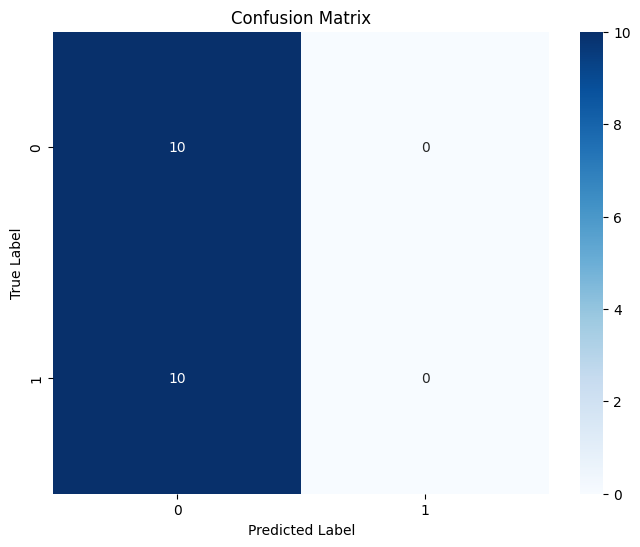

In [78]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Plot ROC curve

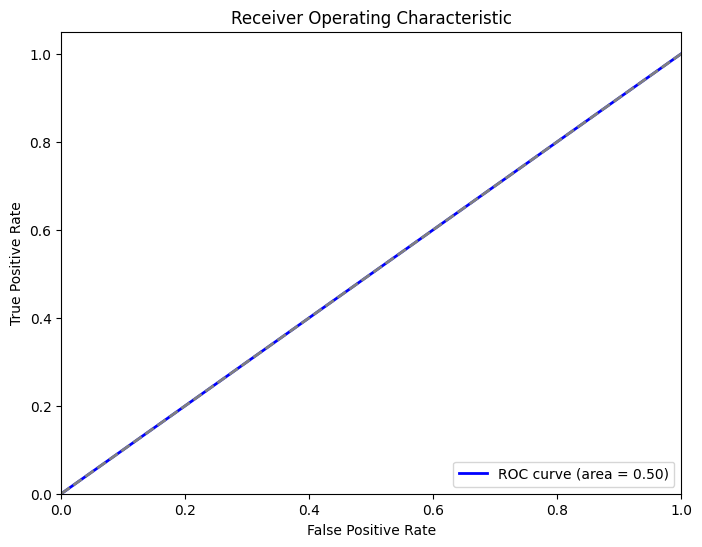

In [79]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Feature importance

In [80]:
feature_importances = pd.DataFrame(
    gb_model.feature_importances_,
    index=X.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

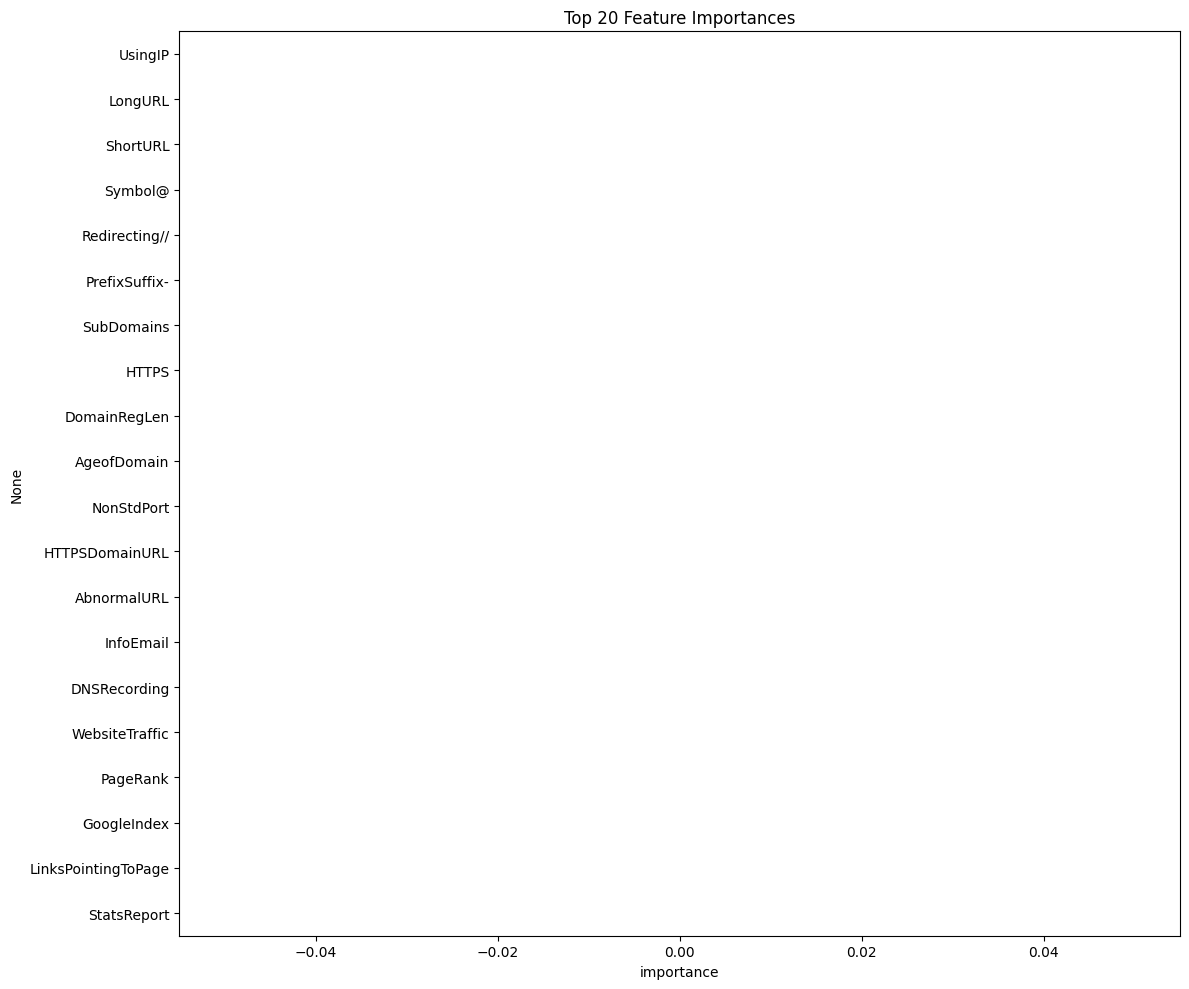

In [84]:
plt.figure(figsize=(12, 10))
sns.barplot(x=feature_importances['importance'].head(20), y=feature_importances.index[:20])
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

In [85]:
evaluation_time = time.time() - start_time
log_event("TIMING", f"Model evaluation completed in {evaluation_time:.2f} seconds")

[2025-03-24T09:26:33.053717] TIMING: Model evaluation completed in 179.55 seconds


## 7. Save the model

In [86]:
log_event("MODEL_SAVING", "Saving model")
start_time = time.time()

[2025-03-24T09:26:35.124714] MODEL_SAVING: Saving model


### Save the model

In [87]:
joblib.dump(gb_model, MODEL_OUTPUT_PATH)

['/content/drive/MyDrive/PUSL3190/models/gradient_boosting_model/gradient_boost_model.pkl']

### Save the scaler for future preprocessing

In [90]:
joblib.dump(scaler, f'{BASE_PATH}/models/gradient_boosting_model/gradient_boost_scaler.pkl')

['/content/drive/MyDrive/PUSL3190/models/gradient_boosting_model/gradient_boost_scaler.pkl']

### Save feature names for inference

In [92]:
with open(f'{BASE_PATH}/models/gradient_boosting_model/gradient_boost_features.json', 'w') as f:
    json.dump(list(X.columns), f)

### Save model parameters and metadata

In [93]:
model_info = {
    "name": "gradient_boost_v1",
    "type": "gradient_boost",
    "version": "1.0",
    "trained_at": datetime.now().isoformat(),
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "auc": float(roc_auc),
    "parameters": {
        "n_estimators": gb_model.n_estimators,
        "learning_rate": gb_model.learning_rate,
        "max_depth": gb_model.max_depth,
        "min_samples_split": gb_model.min_samples_split,
        "min_samples_leaf": gb_model.min_samples_leaf,
        "subsample": gb_model.subsample
    },
    "feature_importances": feature_importances.head(10).to_dict(),
    "dataset_size": df.shape[0],
    "training_samples": X_train.shape[0],
    "test_samples": X_test.shape[0],
    "features_implemented": list(X.columns)
}

In [95]:
with open(f'{BASE_PATH}/models/gradient_boosting_model/gradient_boost_metadata.json', 'w') as f:
    json.dump(model_info, f, indent=2)

## 8. Hyperparameter Tuning

In [96]:
log_event("HYPERPARAMETER_TUNING", "Starting hyperparameter tuning")
start_time = time.time()

[2025-03-24T09:29:05.810216] HYPERPARAMETER_TUNING: Starting hyperparameter tuning


### Focused parameter grid based on initial model performance

In [97]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [100, 200, 300],
    'min_samples_leaf': [30, 50, 70],
    'subsample': [0.7, 0.8, 0.9]
}

### Subset of data for faster tuning

In [100]:
X_tune = X_train_scaled[:20000]  # Use first 20k samples for tuning
y_tune = y_train[:20000]

### Set up cross-validation grid search

In [101]:
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(
        n_estimators=100,  # Fixed parameter to reduce tuning time
        random_state=42
    ),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='f1',
    n_jobs=-1  # Use all available cores
)

### Run grid search

In [102]:
grid_search.fit(X_tune, y_tune)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'min_samples_leaf': [30, 50, 70],
                         'min_samples_split': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='f1')

In [103]:
tuning_time = time.time() - start_time
log_event("TIMING", f"Hyperparameter tuning completed in {tuning_time:.2f} seconds")

[2025-03-24T09:36:35.735060] TIMING: Hyperparameter tuning completed in 449.92 seconds


### Log the best parameters

In [104]:
log_event("HYPERPARAMETER_TUNING", "Best parameters found", {
    "parameters": grid_search.best_params_,
    "f1_score": float(grid_search.best_score_)
})

[2025-03-24T09:36:39.260948] HYPERPARAMETER_TUNING: Best parameters found


In [105]:
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print(f"Best F1 Score: {grid_search.best_score_:.4f}")


Best Parameters:
learning_rate: 0.05
max_depth: 3
min_samples_leaf: 30
min_samples_split: 100
subsample: 0.7
Best F1 Score: 0.4384


### Final model with the best parameters (on full training data)

In [106]:
final_model = GradientBoostingClassifier(
    n_estimators=100,
    **grid_search.best_params_,
    random_state=42
)

In [107]:
final_model.fit(X_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=30,
                           min_samples_split=100, random_state=42,
                           subsample=0.7)

### Evaluate final model

In [108]:
final_pred = final_model.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test, final_pred)
final_precision = precision_score(y_test, final_pred)
final_recall = recall_score(y_test, final_pred)
final_f1 = f1_score(y_test, final_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [109]:
log_event("FINAL_MODEL_EVALUATION", "Final model performance after tuning", {
    "accuracy": float(final_accuracy),
    "precision": float(final_precision),
    "recall": float(final_recall),
    "f1_score": float(final_f1)
})

[2025-03-24T09:36:58.585705] FINAL_MODEL_EVALUATION: Final model performance after tuning


In [110]:
print("\nFinal Model Performance After Tuning:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")


Final Model Performance After Tuning:
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


### Save all logs to file

In [111]:
saving_time = time.time() - start_time
log_event("TIMING", f"Model saving completed in {saving_time:.2f} seconds")

[2025-03-24T09:37:04.941693] TIMING: Model saving completed in 479.13 seconds


In [112]:
with open(LOG_OUTPUT_PATH, 'w') as f:
    json.dump(log_data, f, indent=2)

### Save the final tuned model

In [114]:
joblib.dump(final_model, f'{BASE_PATH}/models/gradient_boosting_model/gradient_boost_tuned.pkl')

['/content/drive/MyDrive/PUSL3190/models/gradient_boosting_model/gradient_boost_tuned.pkl']

### Save model parameters and metadata for the tuned model

In [115]:
tuned_model_info = {
    "name": "gradient_boost_tuned_v1",
    "type": "gradient_boost",
    "version": "1.0",
    "trained_at": datetime.now().isoformat(),
    "accuracy": float(final_accuracy),
    "precision": float(final_precision),
    "recall": float(final_recall),
    "f1_score": float(final_f1),
    "parameters": {
        "n_estimators": final_model.n_estimators,
        **grid_search.best_params_
    },
    "dataset_size": df.shape[0],
    "training_samples": X_train.shape[0],
    "test_samples": X_test.shape[0]
}

In [117]:
with open(f'{BASE_PATH}/models/gradient_boosting_model/gradient_boost_tuned_metadata.json', 'w') as f:
    json.dump(tuned_model_info, f, indent=2)

In [118]:
print("\n===== TRAINING COMPLETE =====")
print(f"Initial model accuracy: {accuracy:.4f}")
print(f"Final tuned model accuracy: {final_accuracy:.4f}")
print(f"Models saved to {MODEL_OUTPUT_PATH}")
print(f"Logs saved to {LOG_OUTPUT_PATH}")


===== TRAINING COMPLETE =====
Initial model accuracy: 0.5000
Final tuned model accuracy: 0.5000
Models saved to /content/drive/MyDrive/PUSL3190/models/gradient_boosting_model/gradient_boost_model.pkl
Logs saved to /content/drive/MyDrive/PUSL3190/logs/gradient_boost_training_log.json
